### AASD4015 Project 1 Transfer learning Img Classifier, [Comparing the accuarcy and speed of the model](https://)
By Team 55: Chuen Kei Ho 101410183 & Ka Tsun Chan 101420274


Introduction:

For this project we would use the CIFAR10 dataset

We first import VGG16 pretained model, and fine tuned the architect for our dataset. and we compare mparing the accuarcy and speed of the models




*   Model 1a: Training from the Fully Connected Network onwards
*   Model 1b: Un-freezing & training on the LAST CNN block onwards
*   Model 1c: Un-freezing & training on the LAST TWO CNN block onwards
*   Model 2 : unfreezing the last fully connected layers and the last 2 blocks together


CIFAR10 dataset link: https://www.cs.toronto.edu/~kriz/cifar.html

# Transfer learning - Fine-tuning



## Fine Tuning

In [ ]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
import time 
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import matplotlib.pyplot as plt


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
###Preprocessing the data + Resize+ normalize + split the dataset

In [ ]:
# the average and standard deviation of pixel values in the CIFAR10 dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

train_set = datasets.CIFAR10(root='~/.pytorch/CIFAR10',train=True, download=True,transform=transform)
test_set = datasets.CIFAR10(root='~/.pytorch/CIFAR10',train=False, transform=transform)

# Get the labels for the dataset
labels = np.array(train_set.targets)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(sss.split(np.zeros(len(labels)), labels))

train_dataset = torch.utils.data.Subset(train_set, train_indices)
val_dataset = torch.utils.data.Subset(train_set, val_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


Files already downloaded and verified


In [ ]:
#tried to see if the label is good enough
for images, labels in train_loader:
  print(images.size(), labels.size())
  break

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [ ]:
### download and examine the VGG16 model
model1 = models.vgg16(pretrained=True)
model1

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
####freeze all the layers in the neural network and unfreeze them later
for param in model1.parameters():
  param.requires_grad = False

In [ ]:
#examine the classifier layers
model1.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

#### Remove the classifier, and start training from the last layer, replace the fully connected layer , 10 means 10 different classes in the CIFAR 10 dataset

In [ ]:
for i in range(0,7):
  model1.classifier[i].requires_grad = True

In [ ]:
## 10 classes
## using logit instead of softmax for output for numerical stability on small probabilities
model1.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 512),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(512, 10),
                      nn.LogSoftmax(dim=1)
                      )

In [ ]:
#examine the revised model architecture
model1.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [ ]:
#examine the revised model architecture
model1.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

### And we'll use NLLLoss as our criteria and we'll use the Adam optimizer.

In [ ]:
#use negative loglikelihood as criteria
criterion = nn.NLLLoss()

In [ ]:
# Use Adam optimizer
from torch.optim import Adam

model = model1.to(device)
optimizer = Adam(model1.parameters())


In [ ]:
#Specify epoch_number
N_epoch = 5

## Model 1a: Training from the Fully Connected Network onwards

Re-training the model

####to train the model and get the accuracy for freezing everything except the fully connected layers of the VGG16 model.

In [ ]:
model1 = model1.to(device)
optimizer = Adam(filter(lambda p: p.requires_grad, model1.parameters()))

num_epochs = N_epoch
batch_loss = 0
cum_epoch_loss = 0

train_loss_history_1a = []
val_loss_history_1a = []

start_time = time.time()

for e in range(num_epochs):
  
  cum_epoch_loss = 0
  epoch_train_loss = 0.0
  epoch_val_loss = 0.0

  for batch, (images, labels) in enumerate(train_loader,1):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model1(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    
    batch_loss += loss.item()
    epoch_train_loss += loss.item()

    if batch % 100 == 0:
      print(f'Epoch({e+1}/{num_epochs}) : Batch number({batch}/{len(train_loader)}) : Batch loss : {loss.item()}')
  
  epoch_train_loss /= len(train_loader)
  train_loss_history_1a.append(epoch_train_loss)  
   
  
  # Evaluate the model on the validation set
  model1.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)

      logps = model1(images)
      loss = criterion(logps, labels)
      epoch_val_loss += loss.item()

    epoch_val_loss /= len(val_loader)
    val_loss_history_1a.append(epoch_val_loss)

  print(f'Epoch({e+1}/{num_epochs}) : Training loss : {epoch_train_loss} : Validation loss : {epoch_val_loss}')

  
end_time = time.time()
time_elapsed_1a = end_time - start_time
print(time_elapsed_1a)


    

Epoch(1/5) : Batch number(100/625) : Batch loss : 0.6840900182723999
Epoch(1/5) : Batch number(200/625) : Batch loss : 0.636517345905304
Epoch(1/5) : Batch number(300/625) : Batch loss : 0.712063193321228
Epoch(1/5) : Batch number(400/625) : Batch loss : 0.49623575806617737
Epoch(1/5) : Batch number(500/625) : Batch loss : 0.7816985845565796
Epoch(1/5) : Batch number(600/625) : Batch loss : 0.7890834808349609
Epoch(1/5) : Training loss : 0.7156915412902832 : Validation loss : 0.5304992504560264
Epoch(2/5) : Batch number(100/625) : Batch loss : 0.616991400718689
Epoch(2/5) : Batch number(200/625) : Batch loss : 0.4789695739746094
Epoch(2/5) : Batch number(300/625) : Batch loss : 0.2951446771621704
Epoch(2/5) : Batch number(400/625) : Batch loss : 0.3898546099662781
Epoch(2/5) : Batch number(500/625) : Batch loss : 0.4356953501701355
Epoch(2/5) : Batch number(600/625) : Batch loss : 0.2935575842857361
Epoch(2/5) : Training loss : 0.4433053773403168 : Validation loss : 0.44222231085892694

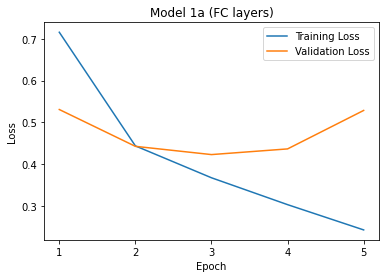

[0.7156915412902832, 0.4433053773403168, 0.36690221750736235, 0.30248703467845917, 0.2419315222978592] [0.5304992504560264, 0.44222231085892694, 0.42247858914030584, 0.43608043195715374, 0.5282842754178746]


In [ ]:
epoch_list = range(1, N_epoch+1)
plt.plot(epoch_list, train_loss_history_1a, label='Training Loss')
plt.plot(epoch_list, val_loss_history_1a, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1a (FC layers)')
plt.legend()
plt.xticks(list(epoch_list))
plt.show()

print(train_loss_history_1a, val_loss_history_1a)

### The accuracy of the model

Test accuracy of model 1a: 82.38%


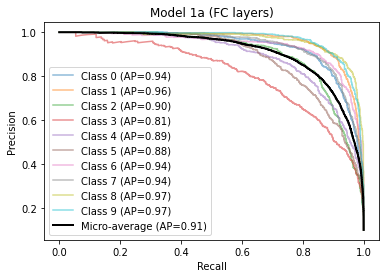

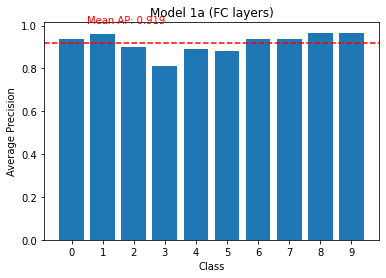

In [ ]:
# model1.to('cpu')

model1.eval()
with torch.no_grad():
    num_correct = 0
    total = 0
    y_true = []
    y_score = []

    #set_trace()
    for batch, (images, labels) in enumerate(test_loader,1):
        images = images.to(device)
        labels = labels.to(device)
        
        logps = model1(images)
        output = torch.exp(logps)

        # collect true labels and predicted scores for each image
        y_true.extend(labels.cpu().numpy())
        y_score.extend(output.cpu().numpy())

        # collect true labels and predicted scores for each image
        y_true.extend(labels.cpu().numpy())
        y_score.extend(output.cpu().numpy())
        
        # count number of correct predictions
        _, predicted = torch.max(logps.data, 1)
        total += labels.size(0)
        num_correct += (predicted == labels).sum().item()

    test_acc_1a = num_correct / total
    print(f'Test accuracy of model 1a: {test_acc_1a:.2%}')
        
    # binarize the true labels
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    y_true_bin = np.array(y_true_bin)
    y_score = np.array(y_score)

    # compute precision-recall curve for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(10):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])
    
    # Compute the micro-average precision-recall curve
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_true_bin, y_score, average="micro")

    # Plot the individual class precision-recall curves with lighter colors and more transparency
    for i in range(10):
      plt.plot(recall[i], precision[i], label=f'Class {i} (AP={average_precision[i]:.2f})', alpha=0.5)

    # Plot the micro-average precision-recall curve with a darker color and no transparency
    plt.plot(recall["micro"], precision["micro"], label=f'Micro-average (AP={average_precision["micro"]:.2f})', color='k', linewidth=2)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Model 1a (FC layers)')
    plt.legend()
    plt.show()
    
    # compute average precision score for each class
    ap = dict()
    for i in range(10):
        ap[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])
    # compute mean average precision score
    mean_ap = np.mean(list(ap.values()))

    # plot average precision score for each class
    fig, ax = plt.subplots()
    ax.bar(range(10), list(ap.values()))
    ax.axhline(mean_ap, color='r', linestyle='--')
    ax.text(0.5, 1.1*mean_ap, f'Mean AP: {mean_ap:.3f}', color='r')
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10))
    ax.set_xlabel('Class')
    ax.set_ylabel('Average Precision')
    plt.title('Model 1a (FC layers)')
    plt.show()



## Model 1b: Un-freezing & training on the LAST CNN block onwards

### Re-training the model

### index 24,31

In [ ]:
#last CNN Block in the feature extraction layers
for i in range(24,31):
  model1.features[i].requires_grad = True


In [ ]:
model1 = model1.to(device)
optimizer = Adam(filter(lambda p: p.requires_grad, model1.parameters()))

train_loss_history_1b = []
val_loss_history_1b = []

num_epochs = N_epoch
batch_loss = 0
cum_epoch_loss = 0


start_time = time.time()


for e in range(num_epochs):
  cum_epoch_loss = 0
  epoch_train_loss = 0.0
  epoch_val_loss = 0.0
  
  for batch, (images, labels) in enumerate(train_loader,1):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model1(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    
    batch_loss += loss.item()
    epoch_train_loss += loss.item()
    
    if batch % 100 == 0:
      print(f'Epoch({e+1}/{num_epochs}) : Batch number({batch}/{len(train_loader)}) : Batch loss : {loss.item()}')
    
  epoch_train_loss /= len(train_loader)
  train_loss_history_1b.append(epoch_train_loss)  
  
  print(f'Training loss : {epoch_train_loss}')    

  model1.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)

      logps = model1(images)
      loss = criterion(logps, labels)
      epoch_val_loss += loss.item()

    epoch_val_loss /= len(val_loader)
    val_loss_history_1b.append(epoch_val_loss)
  print(f'Epoch({e+1}/{num_epochs}) : Training loss : {epoch_train_loss} : Validation loss : {epoch_val_loss}')
    
end_time = time.time()
time_elapsed_1b = end_time - start_time
print(f'Time elapsed: {time_elapsed_1b}')

Epoch(1/5) : Batch number(100/625) : Batch loss : 0.3126363456249237
Epoch(1/5) : Batch number(200/625) : Batch loss : 0.23560450971126556
Epoch(1/5) : Batch number(300/625) : Batch loss : 0.14351831376552582
Epoch(1/5) : Batch number(400/625) : Batch loss : 0.2777788043022156
Epoch(1/5) : Batch number(500/625) : Batch loss : 0.23087279498577118
Epoch(1/5) : Batch number(600/625) : Batch loss : 0.1648556888103485
Training loss : 0.2032847498834133
Epoch(1/5) : Training loss : 0.2032847498834133 : Validation loss : 0.5100589591986054
Epoch(2/5) : Batch number(100/625) : Batch loss : 0.12789654731750488
Epoch(2/5) : Batch number(200/625) : Batch loss : 0.11066015809774399
Epoch(2/5) : Batch number(300/625) : Batch loss : 0.18600352108478546
Epoch(2/5) : Batch number(400/625) : Batch loss : 0.24084503948688507
Epoch(2/5) : Batch number(500/625) : Batch loss : 0.23464010655879974
Epoch(2/5) : Batch number(600/625) : Batch loss : 0.11117836087942123
Training loss : 0.1394808031350374
Epoch(

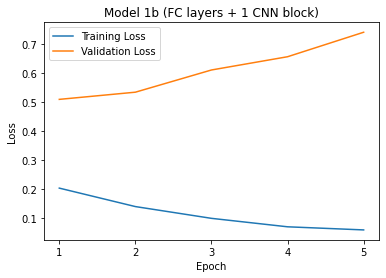

[0.2032847498834133, 0.1394808031350374, 0.09880799189507962, 0.069580611731112, 0.05880574011579156] [0.5100589591986054, 0.5348863711782322, 0.6116535995796228, 0.6574600625688293, 0.7421029358153131]


In [ ]:
plt.plot(epoch_list, train_loss_history_1b, label='Training Loss')
plt.plot(epoch_list, val_loss_history_1b, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1b (FC layers + 1 CNN block)')
plt.legend()
plt.xticks(list(epoch_list))
plt.show()


print(train_loss_history_1b, val_loss_history_1b)

### The accuracy of the model

Test accuracy of Model 1b: 84.20%


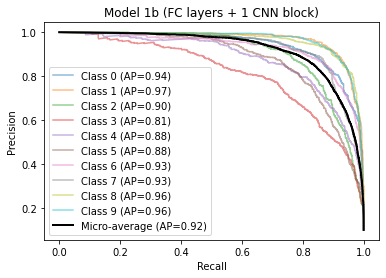

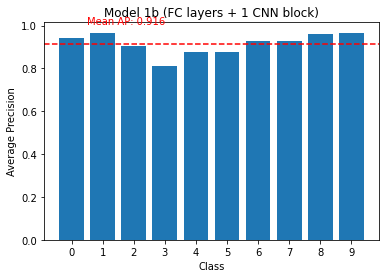

In [ ]:
model1.eval()
with torch.no_grad():
    num_correct = 0
    total = 0
    y_true = []
    y_score = []

    #set_trace()
    for batch, (images, labels) in enumerate(test_loader,1):
        images = images.to(device)
        labels = labels.to(device)
        
        logps = model1(images)
        output = torch.exp(logps)

        # collect true labels and predicted scores for each image
        y_true.extend(labels.cpu().numpy())
        y_score.extend(output.cpu().numpy())

        # collect true labels and predicted scores for each image
        y_true.extend(labels.cpu().numpy())
        y_score.extend(output.cpu().numpy())

        
        # count number of correct predictions
        _, predicted = torch.max(logps.data, 1)
        total += labels.size(0)
        num_correct += (predicted == labels).sum().item()

    test_acc_1b = num_correct / total
    print(f'Test accuracy of Model 1b: {test_acc_1b:.2%}')

    # binarize the true labels
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    y_true_bin = np.array(y_true_bin)
    y_score = np.array(y_score)

    # compute precision-recall curve for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(10):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])
    
    # Compute the micro-average precision-recall curve
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_true_bin, y_score, average="micro")

    # Plot the individual class precision-recall curves with lighter colors and more transparency
    for i in range(10):
      plt.plot(recall[i], precision[i], label=f'Class {i} (AP={average_precision[i]:.2f})', alpha=0.5)

    # Plot the micro-average precision-recall curve with a darker color and no transparency
    plt.plot(recall["micro"], precision["micro"], label=f'Micro-average (AP={average_precision["micro"]:.2f})', color='k', linewidth=2)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Model 1b (FC layers + 1 CNN block)')
    plt.legend()
    plt.show()
    
    # compute average precision score for each class
    ap = dict()
    for i in range(10):
        ap[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])
    # compute mean average precision score
    mean_ap = np.mean(list(ap.values()))

    # plot average precision score for each class
    fig, ax = plt.subplots()
    ax.bar(range(10), list(ap.values()))
    ax.axhline(mean_ap, color='r', linestyle='--')
    ax.text(0.5, 1.1*mean_ap, f'Mean AP: {mean_ap:.3f}', color='r')
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10))
    ax.set_xlabel('Class')
    ax.set_ylabel('Average Precision')
    plt.title('Model 1b (FC layers + 1 CNN block)')
    plt.show()


## Model 1c: Un-freezing & training on the LAST TWO CNN block onwards

### Re-training the model

In [ ]:
for i in range(17, 24):
  model1.features[i].requires_grad = True

In [ ]:
model1 = model.to(device)
optimizer = Adam(filter(lambda p: p.requires_grad, model1.parameters()))

num_epochs = N_epoch
batch_loss = 0
cum_epoch_loss = 0
train_loss_history_1c = []
val_loss_history_1c = []


start_time = time.time()


for e in range(num_epochs):
  cum_epoch_loss = 0
  epoch_train_loss = 0.0
  epoch_val_loss = 0.0
  
  for batch, (images, labels) in enumerate(train_loader,1):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    
    batch_loss += loss.item()
    epoch_train_loss += loss.item()
    
    if batch % 100 == 0:
      print(f'Epoch({e+1}/{num_epochs} : Batch number({batch}/{len(train_loader)}) : Batch loss : {loss.item()}')
    
  epoch_train_loss /= len(train_loader)
  train_loss_history_1c.append(epoch_train_loss)  
  
  print(f'Training loss : {epoch_train_loss}')     

  model1.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)

      logps = model1(images)
      loss = criterion(logps, labels)
      epoch_val_loss += loss.item()

    epoch_val_loss /= len(val_loader)
    val_loss_history_1c.append(epoch_val_loss)
  
  print(f'Epoch({e+1}/{num_epochs}) : Training loss : {epoch_train_loss} : Validation loss : {epoch_val_loss}')


end_time = time.time()
time_elapsed_1c = end_time - start_time
    

Epoch(1/5 : Batch number(100/625) : Batch loss : 0.09507538378238678
Epoch(1/5 : Batch number(200/625) : Batch loss : 0.03093002550303936
Epoch(1/5 : Batch number(300/625) : Batch loss : 0.029813159257173538
Epoch(1/5 : Batch number(400/625) : Batch loss : 0.03642086684703827
Epoch(1/5 : Batch number(500/625) : Batch loss : 0.12173967808485031
Epoch(1/5 : Batch number(600/625) : Batch loss : 0.06634120643138885
Training loss : 0.06311396325081586
Epoch(1/5) : Training loss : 0.06311396325081586 : Validation loss : 0.7558970116316133
Epoch(2/5 : Batch number(100/625) : Batch loss : 0.0671524927020073
Epoch(2/5 : Batch number(200/625) : Batch loss : 0.05653967708349228
Epoch(2/5 : Batch number(300/625) : Batch loss : 0.017124051228165627
Epoch(2/5 : Batch number(400/625) : Batch loss : 0.010540752671658993
Epoch(2/5 : Batch number(500/625) : Batch loss : 0.1039067879319191
Epoch(2/5 : Batch number(600/625) : Batch loss : 0.046473268419504166
Training loss : 0.041955139780789616
Epoch(2/5

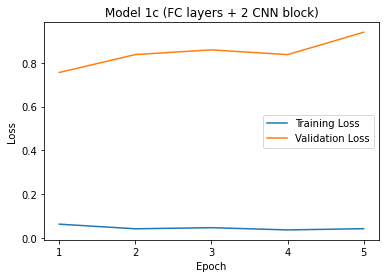

[0.06311396325081586, 0.041955139780789616, 0.04701863550487906, 0.03684139398783445, 0.04240837669083849] [0.7558970116316133, 0.8377063092745983, 0.8591476097987716, 0.8373300740673284, 0.9396238947749898]


In [ ]:
plt.plot(epoch_list, train_loss_history_1c, label='Training Loss')
plt.plot(epoch_list, val_loss_history_1c, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1c (FC layers + 2 CNN block)')
plt.legend()
plt.xticks(list(epoch_list))
plt.show()

print(train_loss_history_1c, val_loss_history_1c)

### The accuracy of the model

Test accuracy for model 1c: 83.96%


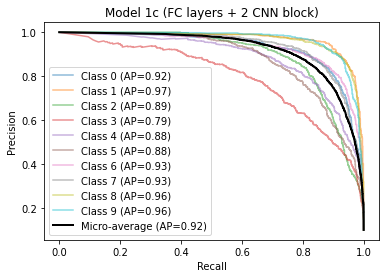

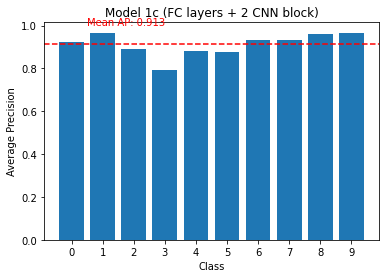

In [ ]:
model1.eval()
with torch.no_grad():
    num_correct = 0
    total = 0
    y_true = []
    y_score = []

    #set_trace()
    for batch, (images, labels) in enumerate(test_loader,1):
        images = images.to(device)
        labels = labels.to(device)
        
        logps = model1(images)
        output = torch.exp(logps)

        # collect true labels and predicted scores for each image
        y_true.extend(labels.cpu().numpy())
        y_score.extend(output.cpu().numpy())

        # collect true labels and predicted scores for each image
        y_true.extend(labels.cpu().numpy())
        y_score.extend(output.cpu().numpy())
        
        # count number of correct predictions
        _, predicted = torch.max(logps.data, 1)
        total += labels.size(0)
        num_correct += (predicted == labels).sum().item()

    test_acc_1c = num_correct / total
    print(f'Test accuracy for model 1c: {test_acc_1c:.2%}')

    # binarize the true labels
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    y_true_bin = np.array(y_true_bin)
    y_score = np.array(y_score)

    # compute precision-recall curve for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(10):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])
    
    # Compute the micro-average precision-recall curve
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_true_bin, y_score, average="micro")

    # Plot the individual class precision-recall curves with lighter colors and more transparency
    for i in range(10):
      plt.plot(recall[i], precision[i], label=f'Class {i} (AP={average_precision[i]:.2f})', alpha=0.5)

    # Plot the micro-average precision-recall curve with a darker color and no transparency
    plt.plot(recall["micro"], precision["micro"], label=f'Micro-average (AP={average_precision["micro"]:.2f})', color='k', linewidth=2)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Model 1c (FC layers + 2 CNN block)')
    plt.legend()
    plt.show()
    
    # compute average precision score for each class
    ap = dict()
    for i in range(10):
        ap[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])
    # compute mean average precision score
    mean_ap = np.mean(list(ap.values()))

    # plot average precision score for each class
    fig, ax = plt.subplots()
    ax.bar(range(10), list(ap.values()))
    ax.axhline(mean_ap, color='r', linestyle='--')
    ax.text(0.5, 1.1*mean_ap, f'Mean AP: {mean_ap:.3f}', color='r')
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10))
    ax.set_xlabel('Class')
    ax.set_ylabel('Average Precision')
    plt.title('Model 1c (FC layers + 2 CNN block)')
    plt.show()
    

# Model 2 - unfreezing the last fully connected layers and the last 2 blocks together 




### copy the VGG16 model

In [ ]:
model2 =models.vgg16(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#######freeze all the layers of the network

In [ ]:
for param in model2.parameters():
  param.requires_grad = False



```
# This is formatted as code
```

#### Remove the classifier, and start training from the last layer, replace the fully connected layer , 10 means 10 different classes in the CIFAR 10 dataset

In [ ]:
for i in range(0,7):
  model2.classifier[i].requires_grad = True

In [ ]:
model2.classifier[6] = nn.Sequential(
                      nn.Linear(4096,512),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(512,10),
                      nn.LogSoftmax(dim=1)
                      )


### And we'll use NLLLoss as our criteria and we'll use the Adam optimizer.

In [ ]:
criterion2 = nn.NLLLoss()

In [ ]:
from torch.optim import Adam

model2 = model2.to(device)
optimizer2 = Adam(model2.parameters())


#### unfreeze the last TWO CNN Blocks and the classifier

In [ ]:
for i in range(17,31):
  model2.features[i].requires_grad = True

In [ ]:
model2 = model2.to(device)
optimizer2 = Adam(filter(lambda p: p.requires_grad, model2.parameters()))

num_epochs = N_epoch
batch_loss2 = 0
cum_epoch_loss2 = 0
train_loss_history_2 = []
val_loss_history_2 = []

start_time = time.time()


for e in range(num_epochs):
  cum_epoch_loss2 = 0
  epoch_train_loss = 0.0
  epoch_val_loss = 0.0
  
  for batch, (images, labels) in enumerate(train_loader,1):
    images = images.to(device)
    labels = labels.to(device)

    optimizer2.zero_grad()
    logps2 = model2(images)
    loss2 = criterion2(logps2, labels)
    loss2.backward()
    optimizer2.step()
    
    batch_loss2 += loss2.item()
    epoch_train_loss += loss.item()
    if batch % 100 == 0:
      print(f'Epoch({e+1}/{num_epochs} : Batch number({batch}/{len(train_loader)}) : Batch loss : {loss2.item()}')

    epoch_train_loss /= len(train_loader)
    train_loss_history_2.append(epoch_train_loss)

  print(f'Training loss : {epoch_train_loss}')

  model2.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)

      logps = model2(images)
      loss = criterion(logps, labels)
      epoch_val_loss += loss.item()

  epoch_val_loss /= len(val_loader)
  val_loss_history_2.append(epoch_val_loss)  
  print(f'Epoch({e+1}/{num_epochs}) : Training loss : {epoch_train_loss} : Validation loss : {epoch_val_loss}')


end_time = time.time()
time_elapsed_2 = end_time - start_time

#### plot the loss against epoch

In [ ]:
plt.plot(epoch_list, train_loss_history_2, label='Training Loss')
plt.plot(epoch_list, val_loss_history_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 (FC layers + 2 CNN blocks trained together)')
plt.legend()
plt.xticks(list(epoch_list))
plt.show()

print(train_loss_history_2, val_loss_history_2)

### The accuracy of the model

In [ ]:
model2.eval()
with torch.no_grad():
    num_correct = 0
    total = 0
    y_true = []
    y_score = []

    #set_trace()
    for batch, (images, labels) in enumerate(test_loader,1):
        images = images.to(device)
        labels = labels.to(device)
        
        logps = model1(images)
        output = torch.exp(logps)

        # collect true labels and predicted scores for each image
        y_true.extend(labels.cpu().numpy())
        y_score.extend(output.cpu().numpy())

        # collect true labels and predicted scores for each image
        y_true.extend(labels.cpu().numpy())
        y_score.extend(output.cpu().numpy())
        
        # count number of correct predictions
        _, predicted = torch.max(logps.data, 1)
        total += labels.size(0)
        num_correct += (predicted == labels).sum().item()

    test_acc_2 = num_correct / total
    print(f'Test accuracy of Model 2: {test_acc_2:.2%}')

    # binarize the true labels
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    y_true_bin = np.array(y_true_bin)
    y_score = np.array(y_score)

    # compute precision-recall curve for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(10):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])
    
    # Compute the micro-average precision-recall curve
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_true_bin, y_score, average="micro")

    # Plot the individual class precision-recall curves with lighter colors and more transparency
    for i in range(10):
      plt.plot(recall[i], precision[i], label=f'Class {i} (AP={average_precision[i]:.2f})', alpha=0.5)

    # Plot the micro-average precision-recall curve with a darker color and no transparency
    plt.plot(recall["micro"], precision["micro"], label=f'Micro-average (AP={average_precision["micro"]:.2f})', color='k', linewidth=2)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Model 2 (FC layers + 2 CNN blocks trained together)')
    plt.legend()
    plt.show()
    
    # compute average precision score for each class
    ap = dict()
    for i in range(10):
        ap[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])
    # compute mean average precision score
    mean_ap = np.mean(list(ap.values()))

    # plot average precision score for each class
    fig, ax = plt.subplots()
    ax.bar(range(10), list(ap.values()))
    ax.axhline(mean_ap, color='r', linestyle='--')
    ax.text(0.5, 1.1*mean_ap, f'Mean AP: {mean_ap:.3f}', color='r')
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10))
    ax.set_xlabel('Class')
    ax.set_ylabel('Average Precision')
    plt.title('Model 2 (FC layers + 2 CNN blocks trained together)')
    plt.show()
    

#### compared time required for training 3 blocks separately (2 blocks of CNN + 1 classifier layer) VS  that for training 3 blocks together

In [ ]:
time_elapsed_1 = time_elapsed_1a + time_elapsed_1b + time_elapsed_1c
print(time_elapsed_1)
print(time_elapsed_2)




In [ ]:
from tabulate import tabulate

# Create a list of variable names and their corresponding values
data = [
    ("time_elapsed_1a", time_elapsed_1a),
    ("time_elapsed_1b", time_elapsed_1b),
    ("time_elapsed_1c", time_elapsed_1c),
    ("-", "-"),
    ("time_elapsed_1", time_elapsed_1),
    ("time_elapsed_2", time_elapsed_2),
]

# Format the table with headers
table = tabulate(data, headers=["Training time required", "time (second)"], tablefmt="grid", floatfmt=".5f")

# Print the formatted table
print(table)

In [ ]:
# Create a list of variable names and their corresponding values
data = [
    ("Model 1a", test_acc_1a),
    ("Model 1b", test_acc_1b),
    ("Model 1c", test_acc_1c),
    ("-", "-"),
    ("Model 2", test_acc_2),
]

# Format the table with headers
table = tabulate(data, headers=["Model", "Accuracy"], tablefmt="grid", floatfmt=".5f")

# Print the formatted table
print(table)